In [1]:
import pandas as pd
import os
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

## EDA and Data Processing

In [2]:
df_i = pd.read_csv('heart.csv')

In [3]:
df_i.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,55,M,ASY,140,217,0,Normal,111,Y,5.6,Down,1
1,50,M,ASY,140,231,0,ST,140,Y,5.0,Flat,1
2,51,M,ASY,140,298,0,Normal,122,Y,4.2,Flat,1
3,61,M,ASY,120,282,0,ST,135,Y,4.0,Down,1
4,64,M,ASY,134,273,0,Normal,102,Y,4.0,Down,1


In [4]:
print('column headers = \n')
cols = df_i.columns
for i in cols:
    print(i)

column headers = 

Age
Sex
ChestPainType
RestingBP
Cholesterol
FastingBS
RestingECG
MaxHR
ExerciseAngina
Oldpeak
ST_Slope
HeartDisease


In [5]:
df_i.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

### Object columns needs encoded
#### OHE is chosen for all columns containing more than 2 categories and because all object columns contain nominal data.  Columns with binary values are label encoded.  I overlooked this until the first One Hot Encoding pass.

In [6]:
object_cols = df_i.select_dtypes(include='object') 
object_cols = list(object_cols.columns)

Legend = [] #keep a legend of label encoded columns
Labels = [] #used to bookkeep the legend

ohc = OneHotEncoder()
le = LabelEncoder()

data_ohc = df_i.copy()

for col in object_cols:
    dat = np.array(data_ohc[col])
    data_ohc = data_ohc.drop(col, axis=1) #drop this column name, look along column
    
    if df_i[col].nunique() == 2:
        new_dat = le.fit_transform(dat) #label encode binary valued columns
        data_ohc[col] = new_dat #overwrite columns
        Legend.append(np.array(le.classes_)) #keep track of what the encoding is
        Labels.append(col)
    else: 
        new_dat = ohc.fit_transform(dat.reshape(-1,1)) #ohc takes this [[], [], ..., []] format
        n_cols = new_dat.shape[1] #grab the number of OHC columns
        feature_names = ohc.get_feature_names()
        feature_names = [i.split('_')[-1] for i in feature_names] #clean up new column names
        col_names = ['_'.join([col, str(x)]) for x in feature_names] #clean up new column names

        new_df = pd.DataFrame(new_dat.toarray(), 
                              index=data_ohc.index,
                              columns=col_names)

        data_ohc = pd.concat([data_ohc, new_df],axis=1) #axis = 1 tells it to join on index.  Omission appends dfs rowwise


df_legend = pd.DataFrame(Legend, index = Labels)

df_legend = df_legend.transpose()

In [7]:
#in case we need a reference for what the label encoded values are
df_legend

,Sex,ExerciseAngina
0,F,N
1,M,Y


### Let's have a look at which features are most strongly correllated with the target.

In [8]:
df_corr = data_ohc.corr()
target_corr = df_corr.HeartDisease.sort_values(ascending = False).to_frame()

target_corr.drop('HeartDisease')


,HeartDisease
ST_Slope_Flat,0.554134
ChestPainType_ASY,0.516716
ExerciseAngina,0.494282
Oldpeak,0.403951
Sex,0.305445
Age,0.282039
FastingBS,0.267291
ST_Slope_Down,0.122527
RestingBP,0.107589
RestingECG_ST,0.102527


In [9]:
data_ohc.to_csv('encoded_data.csv')
df_corr.to_csv('correlations.csv')

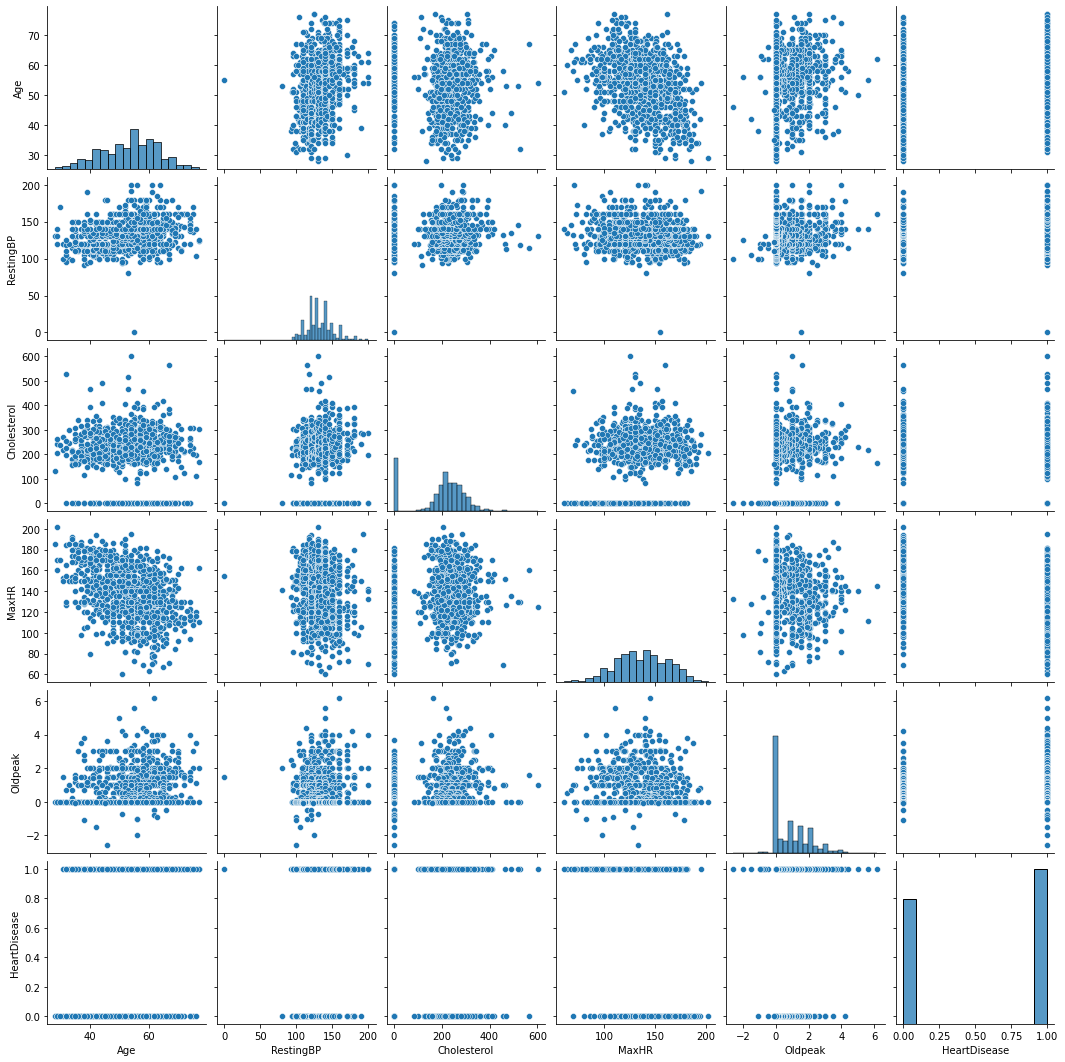

In [10]:
sns.pairplot(df_i.drop(['FastingBS'], axis = 1)) #the scatter plots of the OHE data didn't seem useful. Also dropped the fasting bs column

In [11]:
df_p = data_ohc.copy() #rename my df so it is easier to type.

In [12]:
df_p['Cholesterol'].value_counts() #this is unweildy for continuously valued features 
print('observations missing cholesterol measurement = ', len(df_p[df_p['Cholesterol']==0]))

df_NC = df_p[df_p['Cholesterol']==0] #subset of data where Cholesterol = 0
print('No cholesterol measurement and Heart Disease = ', len(df_NC[df_NC['HeartDisease']==1]))


observations missing cholesterol measurement =  172
No cholesterol measurement and Heart Disease =  152


#### From the pairplot above we find that many observations are missing a cholesterol measurement.  This is the first bifurcation in the analysis.  I am inclined to remove all 172 columns without this measurement and train the model on the remaining dataset.  However, this seems heavily weighted towards paitents with heart disease as 152 if the 172 without a cholesterol measurement have the diagnosis.  

#### It may be that the doctor was able to diagnos these paitents without this test.  I will leave this feature alone and build the models keeping in mind that a missing cholesterol measurement may be biased towards heart disease.

## Test train split for model building

In [13]:
X = df_p.drop(["HeartDisease"], axis = 1)
y = df_p['HeartDisease']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
st = StandardScaler()
X_test_ss = st.fit_transform(X_test)



## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegressionCV

lr_l2 = LogisticRegressionCV(Cs=[1e-5,1e-4,.001,.01,1,5,10], cv=5, penalty='l2', solver='liblinear', scoring = 'recall')

lr_l2.fit(X_train_ss,y_train)

LogisticRegressionCV(Cs=[1e-05, 0.0001, 0.001, 0.01, 1, 5, 10], cv=5,
                     scoring='recall', solver='liblinear')

In [16]:
y_pred_log = lr_l2.predict(X_test_ss)
lr_l2.C_

array([5.])

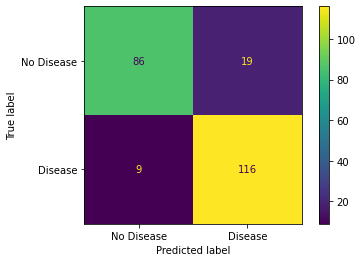

In [17]:
plot_confusion_matrix(lr_l2,X_test_ss, y_test,values_format='d',display_labels=["No Disease", "Disease"])

In [18]:
y_pred = y_pred_log
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       105
           1       0.86      0.93      0.89       125

    accuracy                           0.88       230
   macro avg       0.88      0.87      0.88       230
weighted avg       0.88      0.88      0.88       230

Accuracy score:  0.88
F1 Score:  0.89


## Support Vector Machine Model

In [19]:
from sklearn.svm import SVC

In [20]:
svc_ = SVC(random_state = 42)

# param_grid = [
#     {"C": [0.5,1,10,100],
#     'gamma':['scale',1,0.1,0.01,0.001,0.0001],
#     'kernel':['rbf']}
# ]

param_grid = [
    {"C": [0.5,8,10,12],
    'gamma':['scale',0.075,0.05,.01, 0.001],
    'kernel':['rbf']}
]

### Instead of looping through the scoring metric, I am doing a few "by hand."  I want to see how each metric performs.  I think in the case of heart disease classification, the optimized model favors false positives to false negatives.

In [21]:
#all possible grid search cv metrics
import sklearn.metrics
for i in sklearn.metrics.SCORERS.keys():
    print(i)

explained_variance
r2
max_error
neg_median_absolute_error
neg_mean_absolute_error
neg_mean_absolute_percentage_error
neg_mean_squared_error
neg_mean_squared_log_error
neg_root_mean_squared_error
neg_mean_poisson_deviance
neg_mean_gamma_deviance
accuracy
top_k_accuracy
roc_auc
roc_auc_ovr
roc_auc_ovo
roc_auc_ovr_weighted
roc_auc_ovo_weighted
balanced_accuracy
average_precision
neg_log_loss
neg_brier_score
adjusted_rand_score
rand_score
homogeneity_score
completeness_score
v_measure_score
mutual_info_score
adjusted_mutual_info_score
normalized_mutual_info_score
fowlkes_mallows_score
precision
precision_macro
precision_micro
precision_samples
precision_weighted
recall
recall_macro
recall_micro
recall_samples
recall_weighted
f1
f1_macro
f1_micro
f1_samples
f1_weighted
jaccard
jaccard_macro
jaccard_micro
jaccard_samples
jaccard_weighted


ACCURACY
{'C': 8, 'gamma': 0.05, 'kernel': 'rbf'}


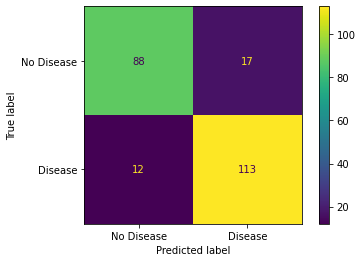

In [22]:
#Accuracy

param_grid = [
    {"C": [0.5,8,10,12],
    'gamma':['scale',0.075,0.05,.01, 0.001],
    'kernel':['rbf']}
]

print('ACCURACY')
optimal_params =GridSearchCV(
SVC(random_state=42),
param_grid,
cv=5,
scoring='accuracy'
)

optimal_params.fit(X_train_ss, y_train)
print(optimal_params.best_params_)

y_pred_a = optimal_params.predict(X_test_ss)

C_best = optimal_params.best_params_["C"]
gamma_best = optimal_params.best_params_["gamma"]
svc1 = SVC(C = C_best, gamma = gamma_best, kernel='rbf')
svc1.fit(X_train_ss,y_train)

plot_confusion_matrix(svc1,X_test_ss, y_test,values_format='d',display_labels=["No Disease", "Disease"])


F1
{'C': 8, 'gamma': 0.05, 'kernel': 'rbf'}


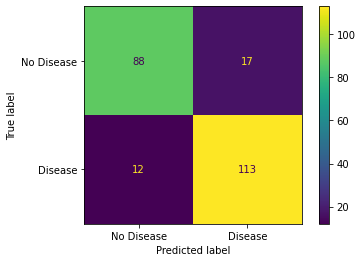

In [23]:
#f1

param_grid = [
    {"C": [.01,0.5,8,10,12],
    'gamma':['scale',0.075,0.05,.01, 0.001],
    'kernel':['rbf']}
]


print('F1')
optimal_params =GridSearchCV(
SVC(random_state=42),
param_grid,
cv=5,
scoring='f1'
)

optimal_params.fit(X_train_ss, y_train)
print(optimal_params.best_params_)

y_pred_f = optimal_params.predict(X_test_ss)

C_best = optimal_params.best_params_["C"]
gamma_best = optimal_params.best_params_["gamma"]
svc1 = SVC(C = C_best, gamma = gamma_best, kernel='rbf')
svc1.fit(X_train_ss,y_train)
plot_confusion_matrix(svc1,X_test_ss, y_test,values_format='d',display_labels=["No Disease", "Disease"])

Recall
{'C': 8, 'gamma': 0.001, 'kernel': 'rbf'}


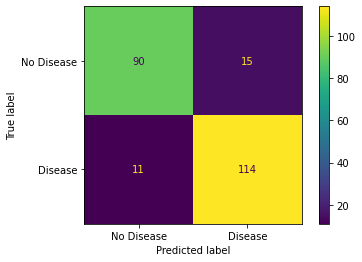

In [24]:
#RECALL
param_grid = [
    {"C": [8,10,12],
    'gamma':['scale',0.075,0.05,.01, 0.001],
    'kernel':['rbf']}
]


print('Recall')
optimal_params =GridSearchCV(
SVC(random_state=42),
param_grid,
cv=5,
scoring='recall'
)

optimal_params.fit(X_train_ss, y_train)
print(optimal_params.best_params_)

y_pred = optimal_params.predict(X_test_ss)

C_best = optimal_params.best_params_["C"]
gamma_best = optimal_params.best_params_["gamma"]
svc1 = SVC(C = C_best, gamma = gamma_best, kernel='rbf')
svc1.fit(X_train_ss,y_train)
plot_confusion_matrix(svc1,X_test_ss, y_test,values_format='d',display_labels=["No Disease", "Disease"])

In [25]:
print("zeros in test data = ", len(y_test) - sum(y_test))
print("ones in test data =", sum(y_test))

zeros in test data =  105
ones in test data = 125


In [26]:
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       105
           1       0.88      0.91      0.90       125

    accuracy                           0.89       230
   macro avg       0.89      0.88      0.89       230
weighted avg       0.89      0.89      0.89       230

Accuracy score:  0.89
F1 Score:  0.9


## SGDclassifier with Nystreom

In [87]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier

nystroem = Nystroem('rbf')

X_train_transformed = nystroem.fit_transform(X_train)
X_test_transformed = nystroem.fit_transform(X_test)
X_transformed = nystroem.fit_transform(X)
param_grid = {'loss':['hinge','log'],
              'penalty':['l2', 'l1'],
              'alpha':[.0001,.001,.01,.1,1]
    
}

optimal_params =GridSearchCV(
SGDClassifier(random_state=42),
param_grid,
cv=5,
scoring='recall'
)


optimal_params.fit(X_train_transformed,y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(random_state=42),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'loss': ['hinge', 'log'], 'penalty': ['l2', 'l1']},
             scoring='recall')

In [88]:
optimal_params.best_estimator_
alpha_b = optimal_params.best_params_['alpha']
loss_b = optimal_params.best_params_['loss']
penalty_b = optimal_params.best_params_['penalty']
SGD = SGDClassifier(alpha = alpha_b, loss = loss_b, penalty = penalty_b)

In [89]:
SGD.fit(X_train_transformed, y_train)
SGD.predict(X_test_transformed)

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1], dtype=int64)

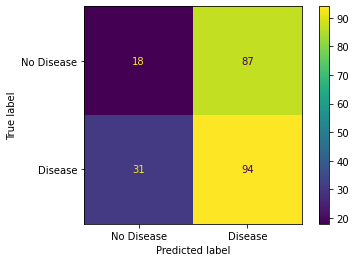

In [90]:
plot_confusion_matrix(SGD,X_test_transformed, y_test,values_format='d',display_labels=["No Disease", "Disease"])

In [93]:
X.shape

(918, 18)

In [97]:
X_transformed

array([[ 6.36326568e-21,  5.46884690e-23,  1.21951001e-08, ...,
         6.09863346e-11,  7.81028652e-25, -2.17479805e-23],
       [ 2.96780489e-19, -7.18826408e-18,  1.86104630e-08, ...,
        -5.11481256e-17,  6.16712181e-20,  1.24029300e-17],
       [ 2.93437835e-20,  1.13671024e-20, -5.02312628e-20, ...,
         9.68890491e-20, -2.59284292e-22, -9.87686272e-20],
       ...,
       [-4.07777410e-17, -5.12412380e-17, -1.42273795e-16, ...,
        -9.40002742e-18,  7.71912992e-17,  7.49567946e-17],
       [ 4.17924057e-20,  4.54171910e-23,  4.43359273e-20, ...,
         5.84211072e-20,  3.08142242e-22, -7.74977439e-05],
       [ 2.46389412e-21, -1.52422328e-20,  1.91362577e-20, ...,
        -2.01350269e-21,  2.77241774e-22, -4.30730960e-19]])

In [98]:
X

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,55,140,217,0,111,5.6,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,0.0,0.0
1,50,140,231,0,140,5.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,1.0,0.0
2,51,140,298,0,122,4.2,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,1.0,0.0
3,61,120,282,0,135,4.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0
4,64,134,273,0,102,4.0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,63,100,0,1,109,-0.9,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0
914,56,115,0,1,82,-1.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,1.0
915,38,100,0,0,179,-1.1,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0,0.0,1.0
916,56,125,0,1,98,-2.0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0
